# Generalization to other model sizes/seq. summary types

## Import packages

In [1]:
save = True

In [2]:
#import packages
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import json

In [3]:
# import from other scripts
import plot_utils
import stats_utils

## Define approach configuration

In [4]:
model_identifier="distilgpt2"

In [5]:
#whether or not to include control condition random nouns (used for SI)
randomnouns=False
length_control=False

In [6]:
# get setting
emb_context="Passage"
split_coord="Sentence"
testonperturbed=False

In [7]:
# function check (this is done in the main function below!)
scores_df = plot_utils.get_best_scores_df(model_identifier=model_identifier,
                                          emb_context=emb_context,
                                          split_coord=split_coord,
                                          testonperturbed=testonperturbed,
                                          randomnouns=randomnouns,length_control=length_control)
scores_df

,score,error,condition,category
0,0.871620,0.077534,original,original
1,0.876199,0.043466,scrambled1,word-order
2,0.876261,0.038490,scrambled3,word-order
3,0.860827,0.048159,scrambled5,word-order
4,0.884308,0.093576,scrambled7,word-order
5,0.795170,0.074308,backward,word-order
6,0.884736,0.096202,lowpmi,word-order
7,0.849663,0.091064,lowpmi-random,word-order
8,0.847025,0.121691,contentwords,information-loss
9,0.815670,0.166101,nounsverbsadj,information-loss


## Plot

In [8]:
#define global figure settings
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)

In [9]:
#define colors
CAT2COLOR = {
    "original": "dimgray",
    #
    "word-order": sns.cubehelix_palette(7, start=.2, rot=-.25, dark=0.2, light=.9, reverse=True),
    "information-loss": sns.cubehelix_palette(5, start=2, rot=0, dark=0.2, light=.85, reverse=True),
    #cut off as last gradient color is similar across colors
    "semantic-distance": sns.light_palette("maroon", 4, reverse=True)[:3],
    #
    "control": "lightgray"
}

if randomnouns:
    CAT2COLOR["information-loss"] = sns.cubehelix_palette(6, start=2, rot=0, dark=0.2, light=.85, reverse=True)

### 3. Define plot function

In [10]:
#!pip install patchworklib

In [11]:
def barplot_multi(list_of_model_identifiers, scores_df, emb_context="Passage", split_coord="Sentence", testonperturbed=False):

    #define global figure settings
    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['svg.fonttype'] = 'none'

    custom_params = {"axes.spines.right": False,
                     "axes.spines.top": False,
                     'ytick.left': True,
                     'xtick.bottom': True,
                     'grid.linestyle': ""  # gets rid of horizontal lines
                     }
    sns.set_theme(font_scale=1, style="white", rc=custom_params)
    #get proportions for subplot width
    categories = ["original", "word-order", "information-loss", "semantic-distance", "control"]
    props = [len(scores_df.loc[scores_df["category"] == cat])/len(scores_df) for cat in categories]

    fig = plt.figure(constrained_layout=True, figsize=(8, 15))
    g = sns.catplot(data=scores_df, x='condition', y='score', hue='model', col='category', kind='bar', sharex=False,
                    facet_kws={'gridspec_kws': {"width_ratios": props}}, aspect=0.35, legend_out=True)
 
          
   # g.map(plt.errorbar, "condition", "score", "error", ls='none', color="k", capsize=5)
    g.set_titles(col_template="{col_name}")
    g.set_xlabels("")
    g.set_ylabels("Normalized predictivity")
    g.set_xticklabels(rotation=80)
    
    if not "gpt2-xl" in list_of_model_identifiers:
        g.set(ylim=(0, 1))
    else:
        g.set(ylim=(0, 1.25))
        
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.75))
    g.fig.tight_layout()
    
    savename = f"match2brain_{'+'.join(list_of_model_identifiers)}_testonperturbed={testonperturbed}"

    if save:
        g.savefig(f'results_paper/SupplementaryInformation/{savename}.svg', dpi=180)
        g.savefig(f'results_paper/SupplementaryInformation/{savename}.png', bbox_inches='tight', dpi=180)

    plt.show()

In [12]:
import pandas as pd

def main_multi(list_of_model_identifiers, emb_context="Passage", split_coord="Sentence", testonperturbed=False):
    frames = []

    for model in list_of_model_identifiers:
        m_scores_df = plot_utils.get_best_scores_df(model, emb_context=emb_context,
                                    split_coord=split_coord, testonperturbed=testonperturbed)
        m_scores_df["model"] = model
        frames.append(m_scores_df)
    
    scores_df = pd.concat(frames)
    #Rename conditions according to new names:
    scores_df['condition'] = scores_df['condition'].map(plot_utils.COND2LABEL)
    
    barplot_multi(list_of_model_identifiers, scores_df, emb_context=emb_context,
            split_coord=split_coord, testonperturbed=testonperturbed)

In [13]:
plotting_models = ["distilgpt2", "gpt2", "gpt2-xl"]

<Figure size 576x1080 with 0 Axes>

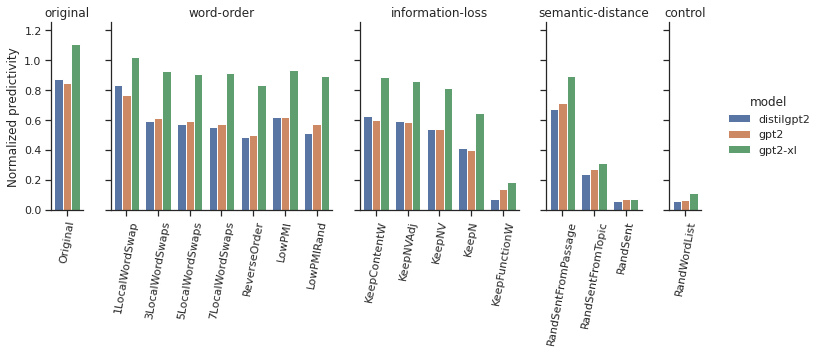

In [14]:
main_multi(plotting_models, testonperturbed=True)

<Figure size 576x1080 with 0 Axes>

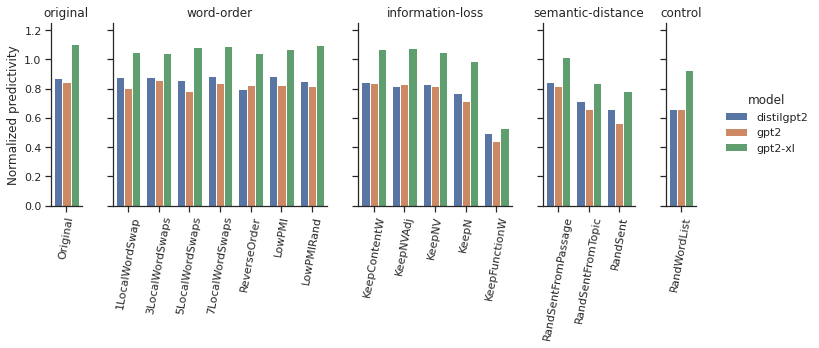

In [15]:
main_multi(plotting_models)

# All models barplot

<Figure size 576x1080 with 0 Axes>

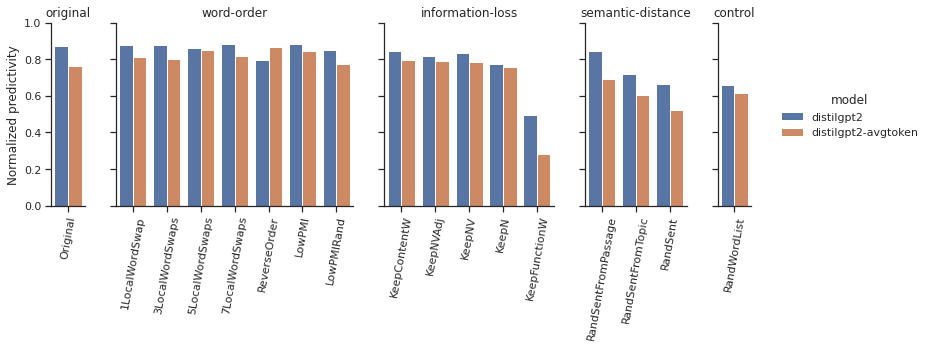

In [16]:
main_multi(["distilgpt2","distilgpt2-avgtoken"])

<Figure size 576x1080 with 0 Axes>

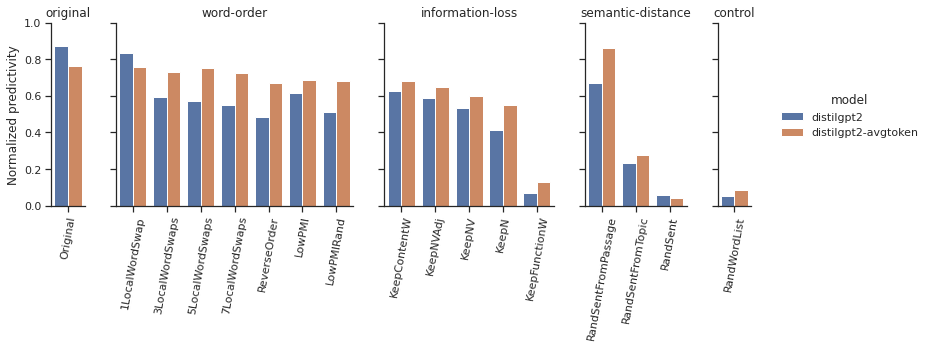

In [17]:
main_multi(["distilgpt2","distilgpt2-avgtoken"], testonperturbed=True)